# Series 8: Neural Networks feat. Cross-Entropy

## Problem 2 (Convolutional Neural Networks)

This notebook simply implements the simple version of the TensorFlow MNIST digit recognition tutorial, located at [www.tensorflow.org/versions/r0.8/tutorials/mnist/beginners/index.html][0].

This implementation simply uses softmax regression, i.e. nonbinary logistic regression (we have more than 2 digits, hence the nonbinary-ness!).

[0]: https://www.tensorflow.org/versions/r0.8/tutorials/mnist/beginners/index.html

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("data/MNIST_data/", one_hot=True)

Extracting data/MNIST_data/train-images-idx3-ubyte.gz
Extracting data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting data/MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
%matplotlib inline

One-hot encoded image label: [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
This one seems to be a '7'.


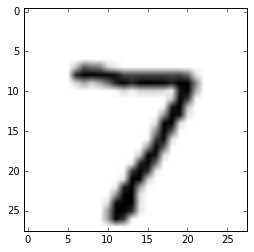

In [3]:
specimen_label = mnist.test.labels[0]
specimen_data = mnist.test.images[0]
print("One-hot encoded image label: {0}".format(specimen_label))
print("This one seems to be a '{0}'.".format(np.argmax(specimen_label)))

plt.imshow(np.reshape(specimen_data, (28, 28)), cmap='Greys')

In [4]:
# This is the placeholder for our main data.
x = tf.placeholder(tf.float32, [None, 784])

# These are our (simple) model parameters.
W = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([10]))

In [5]:
y = tf.nn.softmax(tf.matmul(x, W) + b)

### On Cross Entropy

Formulation (based on Kullback-Leibler divergence of $q$ from $p$:

$$ H(p, q) = -\sum_x p(x) \log{q(x)} \quad \text{for discrete } p \text{ and } q$$

This error is much better than classifcation accuracy, since it also takes into account the *confidence* (i.e. post-sotfmax probability) of the outputs, penalizing e.g. confident mistakes much more than unconfident ones.

Practically, if we are expecting an output to be one (and the others zero, by definition of the one-hot encoding), and it is actually (very close to) one, then the cross-entropy would be:

$$ -(\log(0.001) \cdot 0 + \dots + \log(0.999) \cdot 1 + \dots) = 0 $$

However, if the prediction is less confident, then we want to incur a little bit of error, which is impossible when using just the classification error. For example:

$$ -(\log(0.001) \cdot 0 + \dots + \log(0.6) \cdot 1 + log(0.4) \cdot 0 + \dots) \approx 0.22 $$

Look at the last depicted term. It looks like we're throwing away $\log(0.4)$, since we're multiplying it with 0. However, this is not an issue because we're doing classification. This means that we always expect exactly one output value to be one, so all the error information is already encoded in that term.

As a consequence of this, it can be seen that we only penalize by how wrong the term which should be correct is. We don't care about the distribution of the wrogness in the other terms. This means that we treat a case where the error is spread out among all 0's the same as one where there is just one "close contender", and all the other $k - 2$ activations are basically zero.

Note that for the two above cases, the classification error would have been the same, which is definitely more coarse.

A similar process can be applied for when our prediction is completely wrong. We don't care about who got "elected" first by our NN. We just care that we misfired the output neuron we were supposed to be firing.

Another way to explain this is because softmax normalizes everything. So we can look at softmax as a way of getting some of the other neurons' information into the correct one via.

Main source: https://jamesmccaffrey.wordpress.com/2013/11/05/why-you-should-use-cross-entropy-error-instead-of-classification-error-or-mean-squared-error-for-neural-network-classifier-training/

P.S. An importan quote from the aforementioned main source (emphasis added):

> The discussion above refers to computing error during the **training process**. **After training**, to get an estimate of the effectiveness of the neural network, **classification error is usually preferable to MSE or ACE**. The idea is that classification error is ultimately what you’re interested in.

In [12]:
y_data = tf.placeholder(tf.float32, [None, 10])

# Our training error measurement will be the Average Cross-Entropy (ACE).
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_data * tf.log(y),
                                reduction_indices=[1]))

In [13]:
# Use good old gradient descent to optimize (using a more elaborate
# algorithm such as ADAM is not really necessary here).
train_step = tf.train.GradientDescentOptimizer(learning_rate=0.5).minimize(cross_entropy)

In [14]:
init = tf.initialize_all_variables()

### Training the Model

In [17]:
sess = tf.Session()
sess.run(init)

BATCH_SIZE = 500
EPOCHS = 1000

for epoch in range(EPOCHS):
    # Sample a batch (remember, we're doing Stochastic GD).
    batch_xs, batch_ys = mnist.train.next_batch(BATCH_SIZE)
    # Bind the batch to the placeholders 'x' and 'y_data', then run
    # this chunk of SGD.
    sess.run(train_step, feed_dict={x: batch_xs, y_data: batch_ys})

### Evaluating the Model

In [18]:
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_data,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print(sess.run(accuracy, feed_dict={x: mnist.test.images, y_data: mnist.test.labels}))

0.9206
